# Simulation-Based Disaggregation of Unemployment Data
**Author:** Jiří Landsmann

This notebook demonstrates a simulation-driven pipeline for approximating fine-grained unemployment rates using auxiliary features and partial regional supervision.

The methodology integrates clustering, synthetic label simulation, and supervised learning models to predict district-level unemployment from region-level aggregates.


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


## 1. Data Loading

We load three key datasets:
- **Voting data** (`combined_with_kraj_okres.xlsx`) providing auxiliary features at the district (Okres) level.
- **Unemployment data** (`nezamestnanost.csv`) summarizing official unemployment rates at the regional (Kraj) level.
- **Real district-level unemployment data** (`Formatted_Okres_Data.csv`) used solely for final model validation.

Normalization and cleaning steps ensure consistent naming conventions across datasets.


In [172]:
from sklearn.preprocessing import StandardScaler

# Load data
df_voting = pd.read_excel("DATA/combined_with_kraj_okres.xlsx")
df_okres_unemployment = pd.read_csv("DATA/nezamestnanost.csv")
df_okres_real = pd.read_csv("DATA/Formatted_Okres_Data.csv")

# Normalize names
df_voting["Okres"] = (
    df_voting["Okres"]
    .str.lower()
    .str.replace(" ", "")
    .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
)
df_voting["Kraj"] = (
    df_voting["Kraj"]
    .str.lower()
    .str.replace(" ", "")
    .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
)
df_okres_unemployment["Kraj"] = (
    df_okres_unemployment["Kraj"]
    .str.lower()
    .str.replace(" ", "")
    .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
)
df_okres_real["Okres"] = (
    df_okres_real["Okres"]
    .str.lower()
    .str.replace(" ", "")
    .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
)

# Extract kraj-level summary
df_kraj_summary = df_okres_unemployment.groupby("Kraj")["Podíl nezaměstnaných osob [%]"].mean().reset_index()
df_kraj_variance = df_okres_unemployment.groupby("Kraj")["Podíl nezaměstnaných osob [%]"].var().reset_index()
df_kraj_variance.rename(columns={"Podíl nezaměstnaných osob [%]": "Variance"}, inplace=True)

# Clean numeric voting data
df_voting["Hlasy abs."] = (
    df_voting["Hlasy abs."]
    .astype(str)
    .str.replace("\xa0", "", regex=True)
    .str.replace(",", ".", regex=True)
    .astype(float)
)

# Pivot voting data
df_voting_pivot = df_voting.pivot_table(
    index=["Kraj", "Okres"],
    columns="Volební strana",
    values="Hlasy abs.",
    aggfunc="sum",
    fill_value=0
).reset_index()

# Prepare features
features = df_voting_pivot.columns.drop(["Kraj", "Okres"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_voting_pivot[features])


## 2. Feature Engineering and Clustering

Voting data is aggregated by district and region, and standardized using a `StandardScaler`.

Dynamic clustering is applied:
- The number of clusters per region is adjusted based on unemployment variance.
- Districts are grouped into clusters to reflect internal socio-economic variation.

Simulated unemployment rates are generated per cluster, respecting region-level aggregates and controlling noise.


In [173]:
from sklearn.cluster import KMeans

# Apply dynamic clustering based on variance
clusters = []
for kraj in df_voting_pivot["Kraj"].unique():
    subset = df_voting_pivot[df_voting_pivot["Kraj"] == kraj].copy()
    kraj_variance = df_kraj_variance[df_kraj_variance["Kraj"] == kraj]["Variance"].values[0]

    # Determine number of samples
    num_samples = len(subset)

    # Set desired cluster count dynamically
    if kraj_variance < 0.5:
        desired_clusters = 3
    elif kraj_variance < 1.5:
        desired_clusters = 5
    else:
        desired_clusters = 7

    num_clusters = min(desired_clusters, num_samples)

    if num_clusters < 2:
        subset["Cluster"] = 0
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        subset["Cluster"] = kmeans.fit_predict(subset[features])

    kraj_unemployment = df_kraj_summary[df_kraj_summary["Kraj"] == kraj]["Podíl nezaměstnaných osob [%]"].values[0]

    # Use smaller noise for problematic regions
    if kraj in ["moravskoslezskykraj", "usteckykraj"]:
        std_dev = kraj_unemployment * 0.04
    else:
        std_dev = kraj_unemployment * 0.04

    subset["Simulated_Unemployment"] = np.random.normal(loc=kraj_unemployment, scale=std_dev, size=len(subset))
    subset["Simulated_Unemployment"] = subset["Simulated_Unemployment"].clip(lower=0)

    # Rescale to real kraj mean to avoid bias drift
    sim_mean = subset["Simulated_Unemployment"].mean()
    if sim_mean > 0:
        correction = kraj_unemployment / sim_mean
        subset["Simulated_Unemployment"] *= correction

    clusters.append(subset)

df_clustered = pd.concat(clusters)


## 3. Model Training

Four supervised regression models are trained on the simulated district-level data:
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient boosting Regressor

Models learn to map auxiliary features and cluster labels to predicted unemployment rates.


In [174]:
from sklearn.ensemble import GradientBoostingRegressor

# Add Cluster as a feature to model
features = df_clustered.columns.drop([
    "Kraj", "Okres", "Simulated_Unemployment"
])

# Train models
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

X_train = df_clustered[features]
y_train = df_clustered["Simulated_Unemployment"]

for model_name, model in models.items():
    model.fit(X_train, y_train)
    df_clustered[f"{model_name}_Prediction"] = model.predict(X_train)


## 4. Model Evaluation and Validation

Predictions are validated against real district-level unemployment rates.

Metrics:
- **Mean Absolute Error (MAE)** for overall prediction accuracy.
- (Optional) Pearson correlation to assess monotonic relationships.

Additionally, the simulated unemployment from clustering alone is evaluated as a baseline.


In [175]:
# Merge with real Okres unemployment data for validation
df_final = pd.merge(df_clustered, df_okres_real, on="Okres", how="left")
df_final.rename(columns={"Podíl nezaměstnaných osob [%]": "Real_Unemployment"}, inplace=True)

# Compute MAE for models (handling inconsistent lengths)
for model_name in models.keys():
    valid_rows = df_final[["Real_Unemployment", f"{model_name}_Prediction"]].dropna()
    mae = mean_absolute_error(valid_rows["Real_Unemployment"], valid_rows[f"{model_name}_Prediction"])
    print(f"{model_name} MAE: {mae:.4f}")

# Compute MAE for clustering-based predictions (ensuring consistent data length)
valid_clustering = df_final[["Real_Unemployment", "Simulated_Unemployment"]].dropna()
mae_clustering = mean_absolute_error(valid_clustering["Real_Unemployment"], valid_clustering["Simulated_Unemployment"])
print(f"Mean Absolute Error (MAE) for Clustering Only: {mae_clustering:.4f}")

LinearRegression MAE: 0.6883
DecisionTree MAE: 0.6883
RandomForest MAE: 0.7414
GradientBoosting MAE: 0.6929
Mean Absolute Error (MAE) for Clustering Only: 0.6883


## 5. Saving Detailed Results

The final dataset, including:
- District identifiers
- Clusters
- Simulated unemployment
- Model predictions
- Real unemployment values

...is saved to `final_unemployment_predictions_with_clusters.csv` for further analysis and visualization.


In [176]:
cols = [
    "Kraj",
    "Okres",
    "Real_Unemployment",
    "Simulated_Unemployment",
    "LinearRegression_Prediction",
    "DecisionTree_Prediction",
    "RandomForest_Prediction",
    "GradientBoosting_Prediction",
]

# filtrovat jen existující sloupce, kdybys náhodou některý model neměl
cols = [c for c in cols if c in df_final.columns]

detailed_results = df_final[cols]

print("Detailed prediction results:")
print(detailed_results.head())


Detailed prediction results:
               Kraj             Okres  Real_Unemployment  \
0  hlavnimestopraha  hlavnimestopraha                3.1   
1     jihoceskykraj   ceskebudejovice                2.4   
2     jihoceskykraj      ceskykrumlov                3.5   
3     jihoceskykraj  jindrichuvhradec                2.0   
4     jihoceskykraj             pisek                2.4   

   Simulated_Unemployment  LinearRegression_Prediction  \
0                3.100000                     3.100000   
1                2.712788                     2.712788   
2                2.543610                     2.543610   
3                2.486698                     2.486698   
4                2.612497                     2.612497   

   DecisionTree_Prediction  RandomForest_Prediction  \
0                 3.100000                 3.340932   
1                 2.712788                 3.167814   
2                 2.543610                 2.758392   
3                 2.486698               

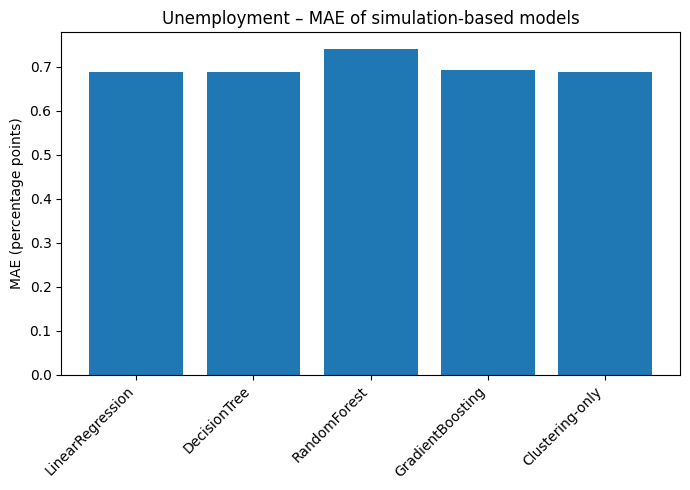

In [177]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

models_unemp = ["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting", "Clustering-only"]
mae_unemp = []

for model_name in models_unemp:
    if model_name == "Clustering-only":
        # čistě simulovaná nezaměstnanost z clusterů
        valid = df_final[["Real_Unemployment", "Simulated_Unemployment"]].dropna()
        y_true = valid["Real_Unemployment"]
        y_pred = valid["Simulated_Unemployment"]
    else:
        col = f"{model_name}_Prediction"
        if col not in df_final.columns:
            raise ValueError(f"Column {col} not found in df_final")
        valid = df_final[["Real_Unemployment", col]].dropna()
        y_true = valid["Real_Unemployment"]
        y_pred = valid[col]

    mae = mean_absolute_error(y_true, y_pred)
    mae_unemp.append(mae)

plt.figure(figsize=(7, 5))
plt.bar(models_unemp, mae_unemp)
plt.xticks(rotation=45, ha="right")
plt.ylabel("MAE (percentage points)")
plt.title("Unemployment – MAE of simulation-based models")
plt.tight_layout()
plt.show()


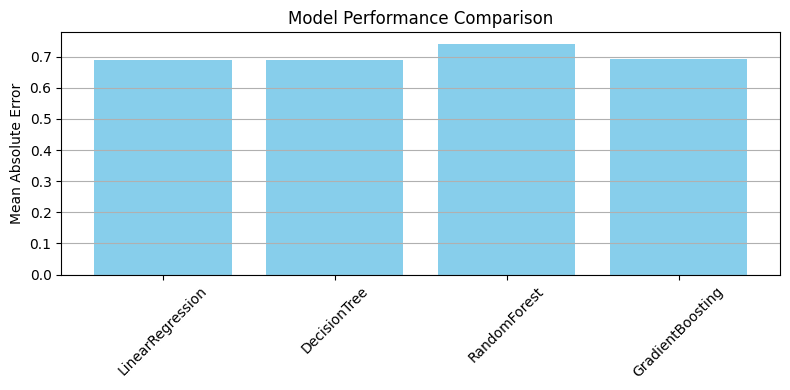

In [178]:
# Calculate and store MAEs
mae_scores = {}

for model_name in models.keys():
    valid_rows = df_final[["Real_Unemployment", f"{model_name}_Prediction"]].dropna()
    mae = mean_absolute_error(valid_rows["Real_Unemployment"], valid_rows[f"{model_name}_Prediction"])
    mae_scores[model_name] = mae

# (Optional) Also add simulated baseline
# valid_clustering = df_final[["Real_Unemployment", "Simulated_Unemployment"]].dropna()
# mae_scores["Simulated Baseline"] = mean_absolute_error(valid_clustering["Real_Unemployment"], valid_clustering["Simulated_Unemployment"])


import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(mae_scores.keys(), mae_scores.values(), color='skyblue')
plt.ylabel("Mean Absolute Error")
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


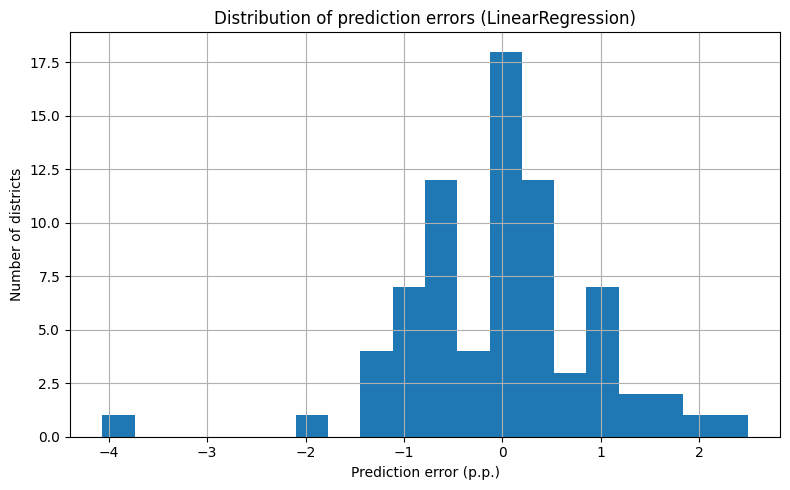

In [179]:
errors = df_final["LinearRegression_Prediction"] - df_final["Real_Unemployment"]

plt.figure(figsize=(8,5))
plt.hist(errors, bins=20)
plt.xlabel("Prediction error (p.p.)")
plt.ylabel("Number of districts")
plt.title("Distribution of prediction errors (LinearRegression)")
plt.grid(True)
plt.tight_layout()
plt.show()


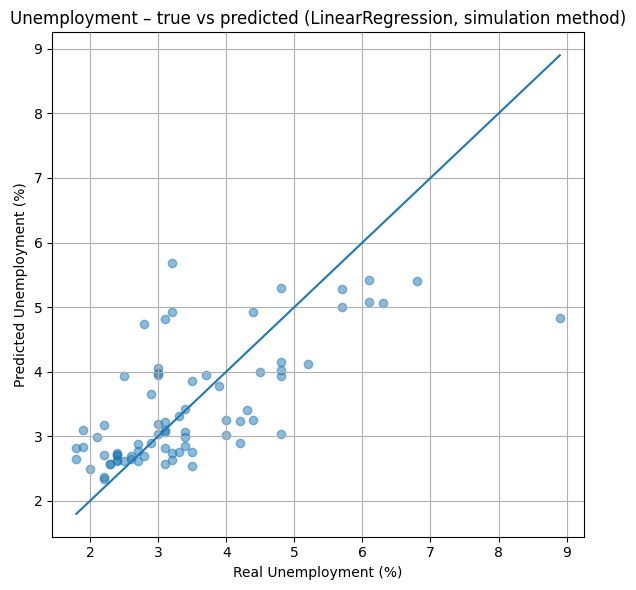

In [180]:
real = df_final["Real_Unemployment"]
pred = df_final["LinearRegression_Prediction"]

min_val = min(real.min(), pred.min())
max_val = max(real.max(), pred.max())

plt.figure(figsize=(6, 6))
plt.scatter(real, pred, alpha=0.5)
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("Real Unemployment (%)")
plt.ylabel("Predicted Unemployment (%)")
plt.title("Unemployment – true vs predicted (LinearRegression, simulation method)")
plt.grid(True)
plt.tight_layout()
plt.show()
